In [1]:
import os
import sys
sys.path.append("/home/ramanav/Projects/Ink-WSI")
from pathlib import Path

import pandas as pd
import numpy as np
import torchvision
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
import torchmetrics

from modules.patch_extraction import SedeenAnnotationParser, ExtractAnnotations
from modules.train_filter import InkGenerator, Handwritten
import trainer
from modules import train_filter
from modules.metrics import ssim, psnr, mse, pbvif


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
template = Handwritten(path="/home/ramanav/Projects/Ink_project/Projects/Dataset/by_class",n=500)

Loading the data...


100%|██████████| 500/500 [00:23<00:00, 21.43it/s]


In [ ]:
ink_generator = InkGenerator(ink_template=template,colors=self.colors)

## To do
- Ink filter all metrics calculation (get table)
- Pair wise patch extraction, of ink and non ink areas, mix both sedeen parser and pair wise extractor
- Use pix2pix for ink removal
- Calculate all the image metrics (get table)

In [2]:
df = pd.read_excel("~/Downloads/pairs.ods")
ink_slide_path = "/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/"
clean_path = "/labs3/amartel_data3/histology/Data/DCIS_cohort/PRECISE_NoRT/"

## Pair wise patch extraction from annotation 

In [3]:
from modules.deploy import Pairwise_ExtractAnnot

ink_slide = str( Path(ink_slide_path) / (str(df["Ink Slides"][0])+".svs" ) )
clean_slide = str( Path(clean_path) / (str(df["Clean Slides"][0])+".svs" ) )
annotation_dir = str( Path(ink_slide_path) / Path("sedeen") )

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"clean":"#00ff00ff","ink":"#ff0000ff"}

dataset = Pairwise_ExtractAnnot(pair_pths=(clean_slide,ink_slide),
                                annotation_dir=annotation_dir,
                                renamed_label=ink_labelset,
                                tile_h=TILE_H,
                                tile_w=TILE_W,
                                tile_stride_factor_h=TILE_STRIDE_FACTOR_H, 
                                tile_stride_factor_w=TILE_STRIDE_FACTOR_W, 
                                lwst_level_idx=LWST_LEVEL_IDX, 
                                mode="train", 
                                train_split=1, 
                                transform=TRANSFORM,
                                sample_threshold=30)

Loading wsis.. 1/1: : 1it [03:56, 236.23s/it]


In [4]:
#Compare with single patch extraction annotation
singledataset = ExtractAnnotations(
        image_pth=ink_slide,
        annotation_dir=annotation_dir,
        renamed_label=ink_labelset,
        tile_h=TILE_H,
        tile_w=TILE_W,
        tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
        tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
        spacing=None,
        lwst_level_idx=LWST_LEVEL_IDX,
        mode="train",
        train_split=1,
        transform=TRANSFORM,
        threshold=0.7,
        sample_threshold=30
        )

Loading wsis.. 1/1: : 1it [01:00, 60.69s/it]


Len of pairwise slides: 2859
Len of single set: 2859
1


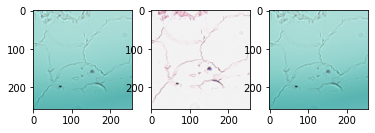

ssim: 0.013357551747010093
psnr: 11.184016828755855
vif: 0.01663175801600034


In [26]:
#Test slides
print(f"Len of pairwise slides: {len(dataset)}\nLen of single set: {len(singledataset)}")

idx = np.random.randint(len(dataset))
ink_patch, clean_patch, label_pair = dataset[idx]
ink_single_patch, label = singledataset[idx]

clean_patch = np.asarray(clean_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_patch = np.asarray(ink_patch.permute(1,2,0).numpy()*255,np.uint8)
ink_single_patch = np.asarray(ink_single_patch.permute(1,2,0).numpy()*255,np.uint8)

fig, ax = plt.subplots(1,3)
print(label_pair)
ax[0].imshow(ink_patch)
ax[1].imshow(clean_patch)
ax[2].imshow(ink_single_patch)
plt.show()

data_range = ink_patch.max() - ink_patch.min()
ssim_without_normalization = ssim(clean_patch, ink_patch)
psnr_without_normalization = psnr(clean_patch, ink_patch)
vif_without_normalization = pbvif(clean_patch, ink_patch)

print("ssim: {}\npsnr: {}\nvif: {}".format(ssim_without_normalization,psnr_without_normalization,vif_without_normalization))


In [11]:
clean_patch*255

array([[[136., 100., 150.],
        [168., 129., 169.],
        [177., 132., 166.],
        ...,
        [245., 240., 239.],
        [243., 242., 243.],
        [243., 243., 244.]],

       [[131.,  94., 152.],
        [166., 123., 176.],
        [174., 125., 172.],
        ...,
        [245., 243., 244.],
        [245., 243., 244.],
        [243., 244., 245.]],

       [[125.,  89., 140.],
        [155., 113., 164.],
        [170., 123., 169.],
        ...,
        [244., 244., 246.],
        [244., 243., 245.],
        [243., 243., 245.]],

       ...,

       [[208., 182., 195.],
        [240., 192., 218.],
        [233., 190., 203.],
        ...,
        [244., 244., 245.],
        [243., 243., 245.],
        [244., 243., 245.]],

       [[250., 211., 211.],
        [234., 189., 211.],
        [232., 194., 213.],
        ...,
        [244., 244., 245.],
        [244., 244., 245.],
        [244., 244., 244.]],

       [[227., 177., 191.],
        [206., 171., 199.],
        [215., 1

## Ink Filter

In [3]:
slide_path = str( Path(ink_slide_path) / (str(df["Ink Slides"][0])+".svs" ) )
xml_path = str( Path(ink_slide_path) / Path("sedeen") / (str(df["Ink Slides"][0]) + ".session.xml" ))

label_set = {"Clean":"#00ff00ff", "Ink":"#ff0000ff"}

annotations = SedeenAnnotationParser(renamed_label=label_set, annular_color="#00ff00ff")
ext_annotation = annotations.parse(xml_path)

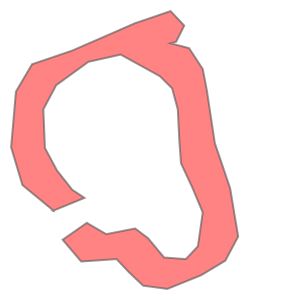

In [4]:
ext_annotation[0]._geometry

In [6]:
slide_path = [str( Path(ink_slide_path) / (str(df["Ink Slides"][i])+".svs" ) ) for i in range(len(df))]
annotation_dir = str( Path(ink_slide_path) / Path("sedeen") )

TILE_H = 256
TILE_W = 256
TILE_STRIDE_FACTOR_H = 1
TILE_STRIDE_FACTOR_W = 1
LWST_LEVEL_IDX = 0
TRANSFORM = torchvision.transforms.ToTensor()
# SPACING = 0.2526
SPACING = None

ink_labelset = {"clean":"#00ff00ff","ink":"#ff0000ff"}

dataset_list = []
for slides in slide_path:
        dataset = ExtractAnnotations(
                image_pth=slides,
                annotation_dir=annotation_dir,
                renamed_label=ink_labelset,
                tile_h=TILE_H,
                tile_w=TILE_W,
                tile_stride_factor_h=TILE_STRIDE_FACTOR_H,
                tile_stride_factor_w=TILE_STRIDE_FACTOR_W,
                spacing=None,
                lwst_level_idx=LWST_LEVEL_IDX,
                mode="train",
                train_split=1,
                transform=TRANSFORM,
                threshold=0.7
                )
        dataset_list.append(dataset)

all_dataset = torch.utils.data.ConcatDataset(dataset_list)

Loading wsis.. 1/1: : 1it [01:00, 60.02s/it]
Loading wsis.. 1/1: : 1it [00:53, 53.30s/it]
Loading wsis.. 1/1: : 1it [01:25, 85.97s/it]
Loading wsis.. 1/1: : 1it [00:55, 55.18s/it]
Loading wsis.. 1/1: : 1it [00:27, 27.52s/it]
Loading wsis.. 1/1: : 1it [01:19, 79.31s/it]
Loading wsis.. 1/1: : 1it [01:16, 76.40s/it]
Loading wsis.. 1/1: : 1it [01:10, 70.66s/it]
Loading wsis.. 1/1: : 1it [01:26, 86.63s/it]
Loading wsis.. 1/1: : 1it [01:34, 94.27s/it]
Loading wsis.. 1/1: : 1it [01:09, 69.24s/it]
Loading wsis.. 1/1: : 1it [00:32, 32.97s/it]
Loading wsis.. 1/1: : 1it [01:15, 75.52s/it]
Loading wsis.. 1/1: : 1it [01:07, 67.85s/it]
Loading wsis.. 1/1: : 1it [02:03, 123.18s/it]


1


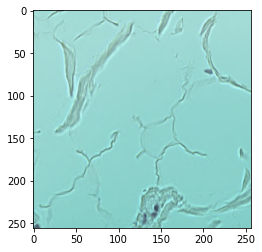

In [59]:
idx = 11
print(all_dataset[idx][1])
plt.imshow(all_dataset[idx][0].permute(1,2,0))

In [22]:
#About dataset
count = {0:0,1:0}
for i in range(len(all_dataset)):
    count[all_dataset[i][1]]+=1
print(count)

{0: 24084, 1: 17596}


In [18]:
#Ink filter model
model_path = "/home/ramanav/Projects/Ink-WSI/Results/filter/Checkpoint_27Jul11_46_05_1.00.pt"
device = torch.device("cuda:3")
model = trainer.Model.create("ink")
model.load_model_weights(model_path,torch.device("cpu"))
model.to(device)

Mnist_model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [27]:
cm = torchmetrics.ConfusionMatrix(num_classes=2)
auroc = torchmetrics.AUROC(pos_label=1)

model.eval()
dataloader = torch.utils.data.DataLoader(all_dataset,batch_size=64)
index = []
with torch.no_grad():
    for i,data in enumerate(tqdm(dataloader)):
        img, label = data
        img = img.to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs.data, 1)
        preds = torch.squeeze(predicted.cpu())
        idx = index.extend(64*i + torch.where(torch.abs(preds-label)==1)[0].numpy())
        soft = torch.nn.functional.softmax(outputs,dim=1).cpu()
        cm(preds,label)
        auroc(soft[:,1],label)
        # break

confusion = cm.compute()
tn = confusion[0,0]
fp = confusion[0,1]
fn = confusion[1,0]
tp = confusion[1,1]

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*(precision*recall)/(precision+recall)
accuracy = (tp+tn)/(tp+fp+fn+tn)

auc = auroc.compute()


print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nAUCROC: {auc}\nConfusion matrix : {confusion}")


  4%|▎         | 23/652 [00:03<01:35,  6.61it/s]/home/ramanav/anaconda3/envs/tiger2/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
100%|██████████| 652/652 [01:27<00:00,  7.49it/s]

tensor([[24072,    12],
        [ 6483, 11113]])
tensor(0.9974)


In [53]:
index[675]

22

3
1


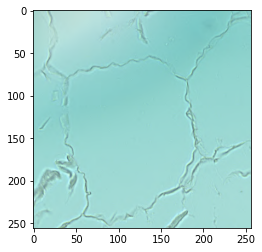

In [51]:
i = np.random.randint(len(index))
print(index[i])
print(all_dataset[index[i]][1])
plt.imshow(all_dataset[index[i]][0].permute(1,2,0))

In [10]:
label


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [25]:
torch.where(torch.abs(preds-label)==1)[0]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 49, 50, 51, 52, 53, 55, 56, 57, 58])

In [39]:
outputs


tensor([[ -5.8004,   5.8371],
        [ -0.7648,   0.8405],
        [  1.5153,  -1.3956],
        [  1.3976,  -1.3111],
        [  4.9750,  -4.7877],
        [ -1.9825,   2.0775],
        [ -3.9017,   3.9368],
        [ -0.4477,   0.5113],
        [  0.7774,  -0.7152],
        [  3.8345,  -3.6900],
        [  3.5905,  -3.4428],
        [  1.6420,  -1.5044],
        [  4.7756,  -4.5800],
        [  6.8575,  -6.6054],
        [  0.4877,  -0.3965],
        [ -2.8823,   2.9008],
        [ -4.7109,   4.7700],
        [  3.1955,  -3.0543],
        [  3.5677,  -3.4396],
        [ -0.1389,   0.1958],
        [ -2.1496,   2.1751],
        [ -3.9579,   3.9924],
        [ -0.8989,   0.9492],
        [  0.3678,  -0.2672],
        [  5.6456,  -5.4284],
        [ -0.2486,   0.3196],
        [ -5.2215,   5.2604],
        [ -5.2722,   5.3135],
        [ -3.0917,   3.1579],
        [ -0.1685,   0.2178],
        [ -2.3110,   2.3768],
        [ -4.6954,   4.7523],
        [ -5.9499,   5.9728],
        [ 

In [44]:
soft[:,1]

tensor([9.9999e-01, 8.3275e-01, 5.1618e-02, 6.2463e-02, 5.7560e-05, 9.8304e-01,
        9.9961e-01, 7.2292e-01, 1.8354e-01, 5.3937e-04, 8.8124e-04, 4.1236e-02,
        8.6468e-05, 1.4228e-06, 2.9230e-01, 9.9693e-01, 9.9992e-01, 1.9272e-03,
        9.0441e-04, 5.8290e-01, 9.8694e-01, 9.9965e-01, 8.6390e-01, 3.4638e-01,
        1.5511e-05, 6.3834e-01, 9.9997e-01, 9.9997e-01, 9.9807e-01, 5.9537e-01,
        9.9088e-01, 9.9992e-01, 9.9999e-01, 9.9995e-01, 6.0331e-02, 7.8173e-08,
        9.9979e-01, 7.1722e-01, 4.9565e-01, 9.9929e-01, 1.0000e+00, 5.8800e-04,
        2.9083e-06, 9.9971e-01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.2752e-05, 2.9654e-04, 2.2302e-05, 9.9796e-01, 9.9999e-01,
        9.9998e-01, 6.3618e-06, 2.8275e-05, 3.6888e-06, 9.9995e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [26]:
slides

'/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121669.svs'

In [27]:
slide_path

['/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121378.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121379.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121623.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121500.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121501.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121531.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/122229.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/122230.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/122232.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121435.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121389.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121393.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121455.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Precise_20x/121668.svs',
 '/amartel_data4/Flow/DCIS_prediction/DCIS_Preci